# Case Study 1

#### Model selection for Clustering

Clustering is unsupervised learning: the resulting clusters are completely derived from data distributed in given a feature set with no class available

Compared to supervised learning counterparts, it is …
* hard to define model performance (cluster quality)
* sensitive to different clustering algorithms and different feature spaces.



#### Task
Your task is to try different clustering algorithms and also a range of the potential parameter(s) which affect the number of clusters including ..

* K-means
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
* Gaussian Mixture Model, 
https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture
* Hierarchical Clustering, 
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering
* Louvain Clustering, 
https://scikit-network.readthedocs.io/en/latest/reference/clustering.html#module-sknetwork.clustering

on 5K colorectal patches represented by 4 different representation PathologyGAN, ResNet50, InceptionV3 and VGG16


#### Data and its preprocessing 
5,000 non-overlapping image patches from hematoxylin & eosin (H&E) stained histological images of human colorectal cancer (CRC) and normal tissue.
* 4 feature sets, PathologyGAN, ResNet50, InceptionV3 and VGG16, are extracted to represent those 5,000 images different dimensional feature spaces.
* PCA and UMAP were employed to reduce each feature sapce into 100-dimensional vectors

* 9 tissue types are also available which include Adipose (ADI), background (BACK), debris (DEB), lymphocytes (LYM), mucus (MUC), smooth muscle (MUS), normal colon mucosa (NORM), cancer-associated stroma (STR), colorectal adenocarcinoma epithelium (TUM)


#### Performance Measurement
To assess quality of clustering solutions, several approaches are expected to be done and interpreted which include...
* Silhouette Score for goodness of fit test
* Vmeasure Score for homogeneity and completeness test (tissue type available as ground truth)
* Clusters visualisations

For more information, please have a check...
https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation


#### Report
Report on your preprocessing pipeline, theory and intuition behinds each algorithm and representation, parameter searching and performance evaluation frameworks. If there is any addiotional process, give evidences/justifications on how it helps.

#### Required Packages

In [1]:
# !pip install h5py==2.10.0
# !pip install numpy
# !pip install pandas
# !pip install sklearn
# !pip install scikit-network
# !pip install pickle-mixin==1.0.2
# !pip install matplotlib
# !pip install plotly

### Prepare Tissue Representations

In [2]:
import h5py
import numpy as np
import pickle

In [3]:
pge_path = 'colon_nct_feature/pge_dim_reduced_feature.h5'
resnet50_path = 'colon_nct_feature/resnet50_dim_reduced_feature.h5'
inceptionv3_path = 'colon_nct_feature/inceptionv3_dim_reduced_feature.h5'
vgg16_path = 'colon_nct_feature/vgg16_dim_reduced_feature.h5'

pge_content = h5py.File(pge_path, mode='r')
resnet50_content = h5py.File(resnet50_path, mode='r')
inceptionv3_content = h5py.File(inceptionv3_path, mode='r')
vgg16_content = h5py.File(vgg16_path, mode='r')


In [4]:
#PCA feature from 4 feature sets: pge_latent, resnet50_latent, inceptionv3_latent, vgg16_latent
pge_pca_feature  = pge_content['pca_feature'][...]
resnet50_pca_feature  = resnet50_content['pca_feature'][...]
inceptionv3_pca_feature = inceptionv3_content['pca_feature'][...]
vgg16_pca_feature  = vgg16_content['pca_feature'][...]

In [5]:
#UMAP feature from 4 feature sets: pge_latent, resnet50_latent, inceptionv3_latent, vgg16_latent
pge_umap_feature  = pge_content['umap_feature'][...]
resnet50_umap_feature = resnet50_content['umap_feature'][...]
inceptionv3_umap_feature  = inceptionv3_content['umap_feature'][...]
vgg16_umap_feature  = vgg16_content['umap_feature'][...]

In [6]:
#tissue type as available ground-truth: labels
filename  = np.squeeze(pge_content['file_name'])
labels = np.array([str(x).split('/')[2] for x in filename])


# Example

In [7]:
import random

In [8]:
random.seed(0)
selected_index = random.sample(list(np.arange(len(pge_pca_feature))), 200)

test_data = pge_pca_feature[selected_index]
test_label = labels[selected_index]

### Exploratory Analysis

In [9]:
import plotly.graph_objects as go
import pandas as pd

In [10]:
traces = []
for name in np.unique(labels):
    trace = go.Scatter3d(
        x=test_data[test_label==name,0],
        y=test_data[test_label==name,1],
        z=test_data[test_label==name,2],
        mode='markers',
        name=name,
        marker=go.scatter3d.Marker(
            size=4,
            opacity=0.8
        )

    )
    traces.append(trace)


data = go.Data(traces)
layout = go.Layout(
            showlegend=True,
    scene=go.Scene(
                xaxis=go.layout.scene.XAxis(title='PC1'),
                yaxis=go.layout.scene.YAxis(title='PC2'),
                zaxis=go.layout.scene.ZAxis(title='PC3')
                )
)
fig = go.Figure(data=data, layout=layout)
fig.update_layout(
    title="First 3 pricipal components of PathologyGAN's PCA feature",
    legend_title="Legend Title",
)

fig.show()


c:\Users\Sahil Gaurkar\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\graph_objs\_deprecations.py:31: DeprecationWarning: plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.

  warnings.warn(
c:\Users\Sahil Gaurkar\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\graph_objs\_deprecations.py:489: DeprecationWarning: plotly.graph_objs.Scene is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Scene

  warnings.warn(


### Model training

In [11]:
# for K-Means
from sklearn.cluster import KMeans
from sknetwork.clustering import Louvain

In [12]:
# for Louvain clustering
from sklearn.metrics import pairwise_distances 
from sklearn.preprocessing import MinMaxScaler
from scipy import sparse


### Evaluation

In [13]:
from sklearn.metrics import silhouette_score, v_measure_score
from sklearn.model_selection import KFold, train_test_split
from decimal import *

In [14]:
def calculate_percent(sub_df, attrib):
    cnt = sub_df[attrib].count()
    output_sub_df = sub_df.groupby(attrib).count()
    return (output_sub_df/cnt)

* Assess goodness of fit by silhouette score and cluster homogeneities by V-measure

In [15]:
def k_means_scores(feature, cluster):
    kmeans_silhouettes = []
    for i in range(2,cluster+1,1):
        kmeans_model = KMeans(n_clusters = i, random_state = 0) 
        kmeans_assignment = kmeans_model.fit_predict(feature)
        kmeans_silhouette = silhouette_score(feature, kmeans_assignment)
        kmeans_silhouettes.append(kmeans_silhouette)
    maxscore = max(kmeans_silhouettes)
    maxindex = kmeans_silhouettes.index(maxscore) + 2
    return kmeans_silhouettes, maxindex

In [16]:
def louvian_scores(feature, res, obj_func, rand_state, max_res):
    louvain_silhouettes = []
    adjacency_matrix = sparse.csr_matrix(MinMaxScaler().fit_transform(-pairwise_distances(feature)))
    max = 0
    max_score = 0
    while res < max_res :
        louvain_model = Louvain(resolution = res, modularity = obj_func, random_state = rand_state) 
        louvain_assignment = louvain_model.fit_transform(adjacency_matrix)
        louvain_silhouette = silhouette_score(feature, louvain_assignment)
        louvain_silhouettes.append(louvain_silhouette)
        if max_score < louvain_silhouette:
            max_score = louvain_silhouette
            max = res
        res = res + 0.01
    return louvain_silhouettes, round(max,4)

### Visualisation

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('figure', figsize=(8.0, 4.0), dpi=140)
from IPython.display import display

In [18]:
def display_info(kmeans_assignment,louvain_assignment,feature):   
    kmeans_silhouette = silhouette_score(feature, kmeans_assignment)
    louvain_silhouette = silhouette_score(feature, louvain_assignment)
    kmeans_v_measure = v_measure_score(labels, kmeans_assignment)
    louvain_v_measure = v_measure_score(labels, louvain_assignment)
    
    kmeans_counts = np.unique(kmeans_assignment, return_counts = True)
    louvain_counts = np.unique(louvain_assignment, return_counts = True)
    
    print('Kmeans assignment counts')
    display(pd.DataFrame({'Cluster Index': kmeans_counts[0], 'Number of members':kmeans_counts[1]}).set_index('Cluster Index'))
    print('Louvain assignment counts')
    display(pd.DataFrame({'Cluster Index': louvain_counts[0], 'Number of members':louvain_counts[1]}).set_index('Cluster Index'))
    display(pd.DataFrame({'Metrics': ['silhouette', 'V-measure'], 'Kmeans': [kmeans_silhouette, kmeans_v_measure], 'Louvain':[louvain_silhouette, louvain_v_measure]}).set_index('Metrics'))

In [19]:
def plot_kmeans_scores(x):
    plt.grid()
    plt.plot(np.arange(2,len(x)+2,1),x,'bs-', label = "silhouette scores")
    plt.xlabel('Clusters')
    plt.ylabel('Score')
    plt.xticks(np.arange(2,len(x)+2,1))
    plt.title('Silhouette scores')
    plt.legend(loc="upper left")

In [20]:
def plot_louvian_scores(x, start_res, max_res):
    plt.grid()
    plt.plot(np.arange(start_res,max_res-0.01,0.01),x,'bs-', label = "silhouette scores")
    plt.xticks(np.arange(start_res,max_res-0.01,0.01), rotation='vertical')
    plt.xlabel('Resolution')
    plt.ylabel('Score')
    plt.title('Resolution scores')
    plt.legend(loc="upper left")

In [21]:
def show_assignments(kmeans_assignment,louvain_assignment):
    
    resulted_cluster_df = pd.DataFrame({'clusterID': kmeans_assignment, 'type': labels})
    label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
    pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')

    f, axes = plt.subplots(1, 2, figsize=(20,5))
    number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
    df_idx = pivoted_label_proportion_df.index
    (pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[0] )

    axes[0].set_ylabel('Percentage of tissue type')
    axes[0].legend(loc='upper right')
    axes[0].set_title('Cluster configuration by Kmeans')

    resulted_cluster_df = pd.DataFrame({'clusterID': louvain_assignment, 'type': labels})
    label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
    pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')

    number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
    df_idx = pivoted_label_proportion_df.index
    (pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[1] )

    axes[1].set_ylabel('Percentage of tissue type')
    axes[1].legend(loc='upper right')
    axes[1].set_title('Cluster configuration by Louvain')
    
    f.show()

### Modeling and Evaluation

Data: PathologyGAN and Inceptionv3

Method: K-Mean and Louvian

Parameters for K-Means

In [22]:
cluster = 30

Parameters for Louvian

In [23]:
start_res = 0.9 #As we have 8 labels available we have to start from 0.9
max_res = 1.1 #Max values upto 1.9
obj_func = 'potts' #Select Objective Functions from : 'newman' or 'potts' undirected graph approch and not 'dugue' as this is an directed graph approch
random_state = 0

Best Score is 0.3079051375389099 for Clusters: 2


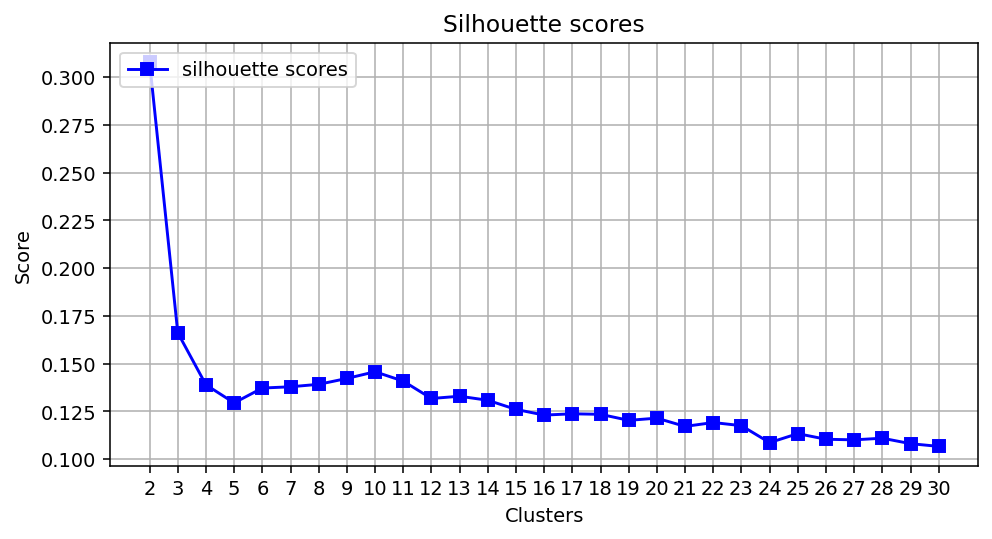

In [24]:
kmeans_silhouettes, kmeans_maxindex = k_means_scores(pge_pca_feature, cluster)
plot_kmeans_scores(kmeans_silhouettes)
print(f'Best Score is {max(kmeans_silhouettes)} for Clusters: {kmeans_maxindex}')

Best Score is 0.09535267949104309 for Resolution: 0.94


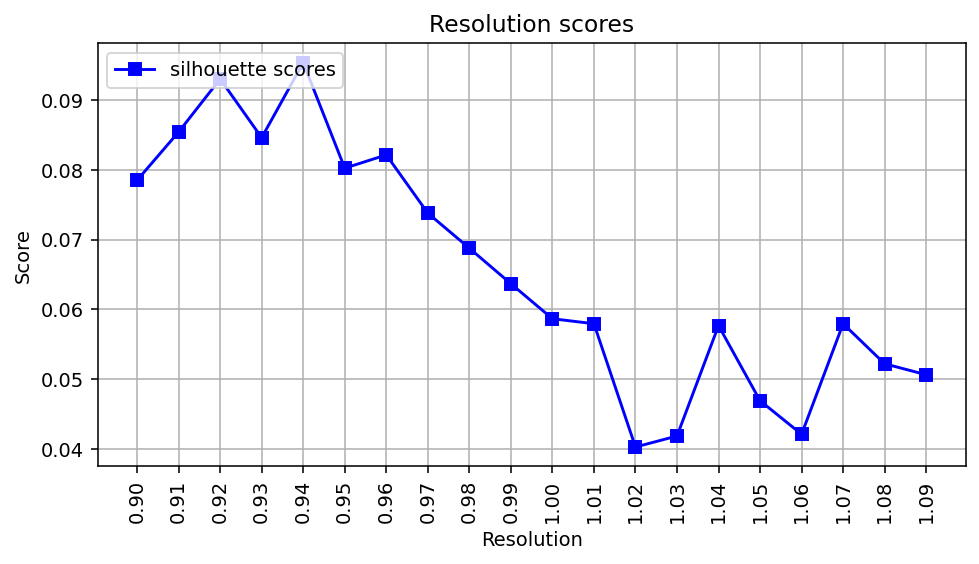

In [25]:
louvian_silhouettes, louvian_maxindex = louvian_scores(pge_pca_feature, start_res, obj_func, random_state, max_res)
plot_louvian_scores(louvian_silhouettes, start_res, max_res)
print(f'Best Score is {max(louvian_silhouettes)} for Resolution: {louvian_maxindex}')

Kmeans assignment counts


,Number of members
Cluster Index,
0,1327
1,3673


Louvain assignment counts


,Number of members
Cluster Index,
0,3844
1,839
2,77
3,39
4,37
5,36
6,20
7,16
8,16


,Kmeans,Louvain
Metrics,,
silhouette,0.307905,0.095353
V-measure,0.203311,0.185348


C:\Users\Sahil Gaurkar\AppData\Local\Temp\ipykernel_14252\2800171252.py:28: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



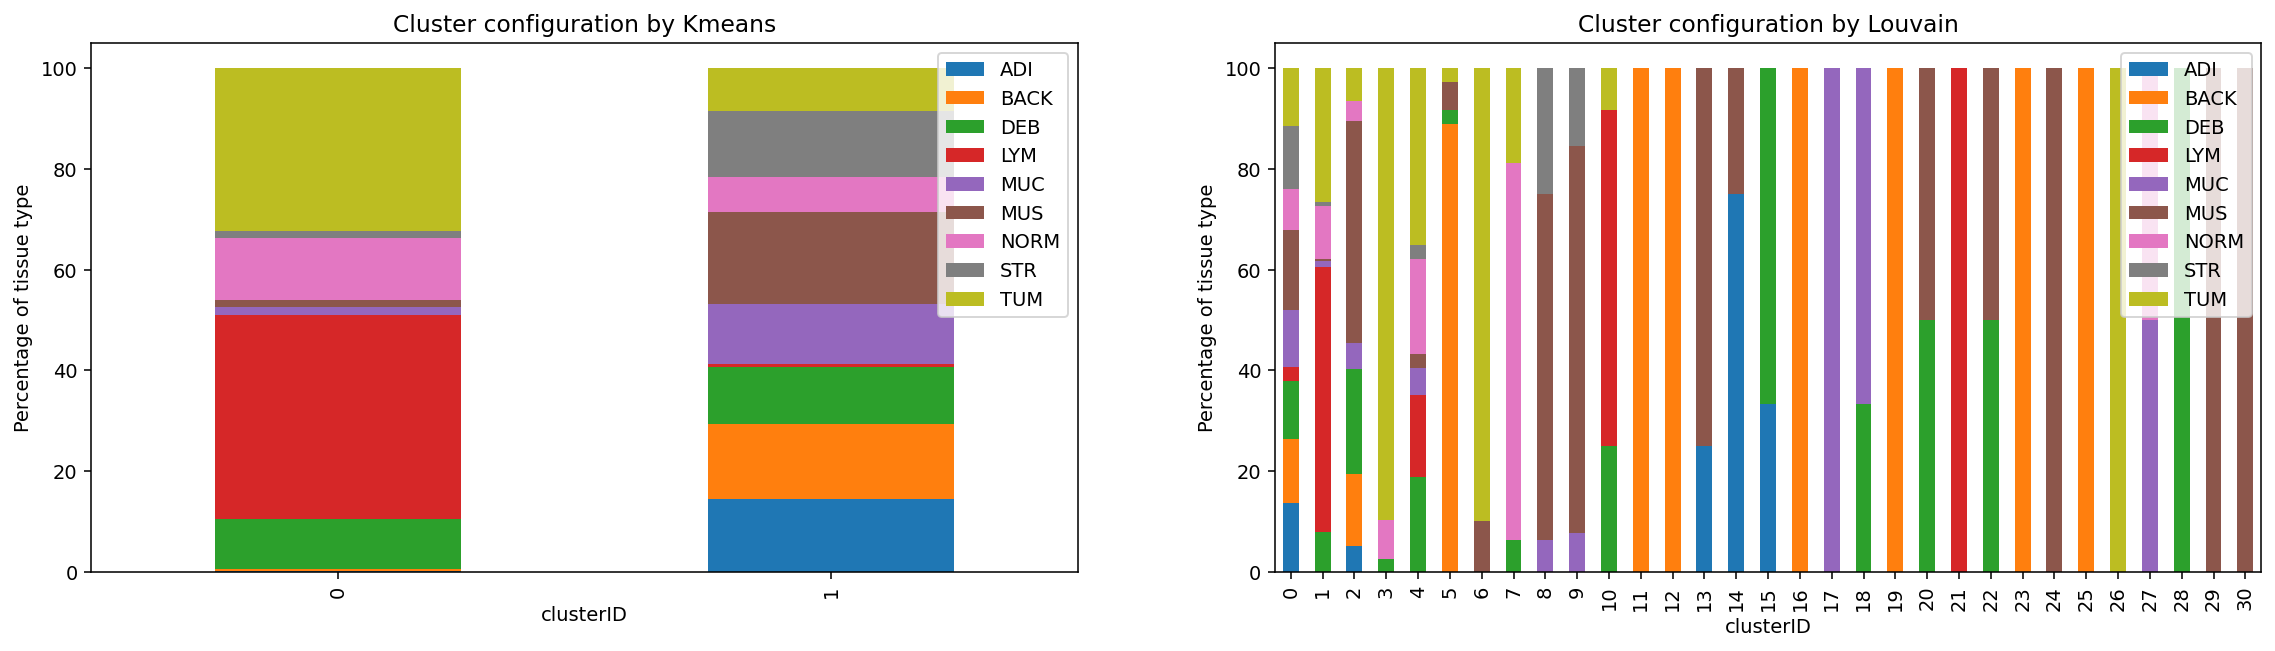

In [26]:
kmeans_model = KMeans(n_clusters = kmeans_maxindex, random_state = 0) 
kmeans_assignment = kmeans_model.fit_predict(pge_pca_feature)

louvain_model = Louvain(resolution = louvian_maxindex, modularity = obj_func, random_state=0) 
adjacency_matrix = sparse.csr_matrix(MinMaxScaler().fit_transform(-pairwise_distances(pge_pca_feature)))
louvain_assignment = louvain_model.fit_transform(adjacency_matrix)

display_info(kmeans_assignment,louvain_assignment,pge_pca_feature)
show_assignments(kmeans_assignment,louvain_assignment)

Best Score is 0.6156871914863586 for Clusters: 7


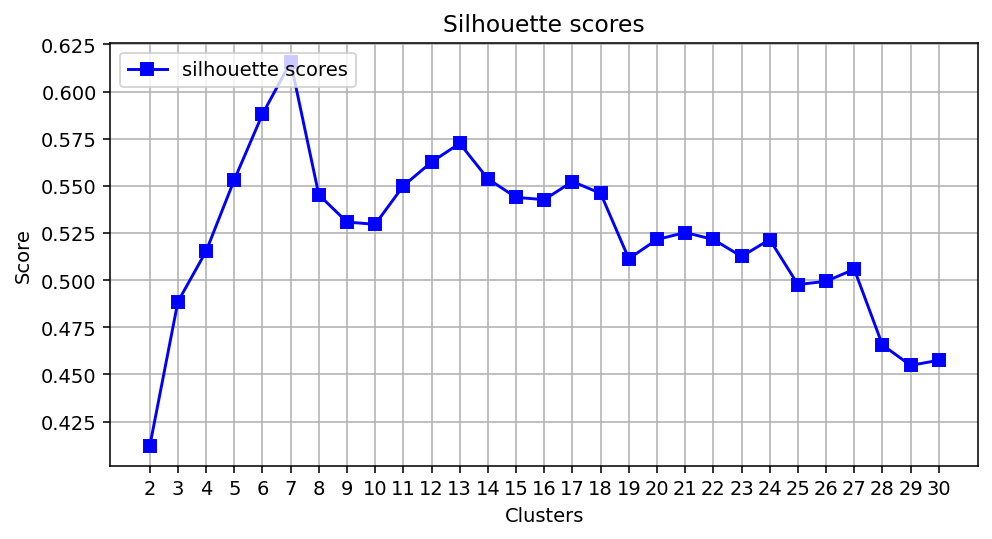

In [27]:
kmeans_silhouettes, kmeans_maxindex = k_means_scores(pge_umap_feature, cluster)
plot_kmeans_scores(kmeans_silhouettes)
print(f'Best Score is {max(kmeans_silhouettes)} for Clusters: {kmeans_maxindex}')

Best Score is 0.5504604578018188 for Resolution: 1.09


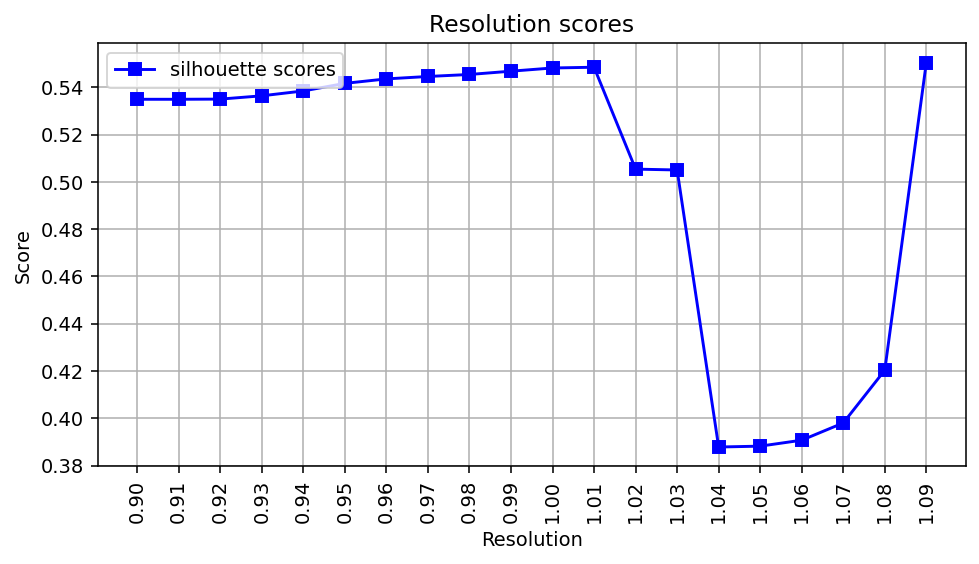

In [28]:
louvian_silhouettes, louvian_maxindex = louvian_scores(pge_umap_feature, start_res, obj_func, random_state, max_res)
plot_louvian_scores(louvian_silhouettes, start_res, max_res)
print(f'Best Score is {max(louvian_silhouettes)} for Resolution: {louvian_maxindex}')

Kmeans assignment counts


,Number of members
Cluster Index,
0,2218
1,386
2,551
3,617
4,1003
5,104
6,121


Louvain assignment counts


,Number of members
Cluster Index,
0,2954
1,937
2,496
3,386
4,119
5,104
6,2
7,1
8,1


,Kmeans,Louvain
Metrics,,
silhouette,0.615687,0.550460
V-measure,0.524363,0.449764


C:\Users\Sahil Gaurkar\AppData\Local\Temp\ipykernel_14252\2800171252.py:28: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



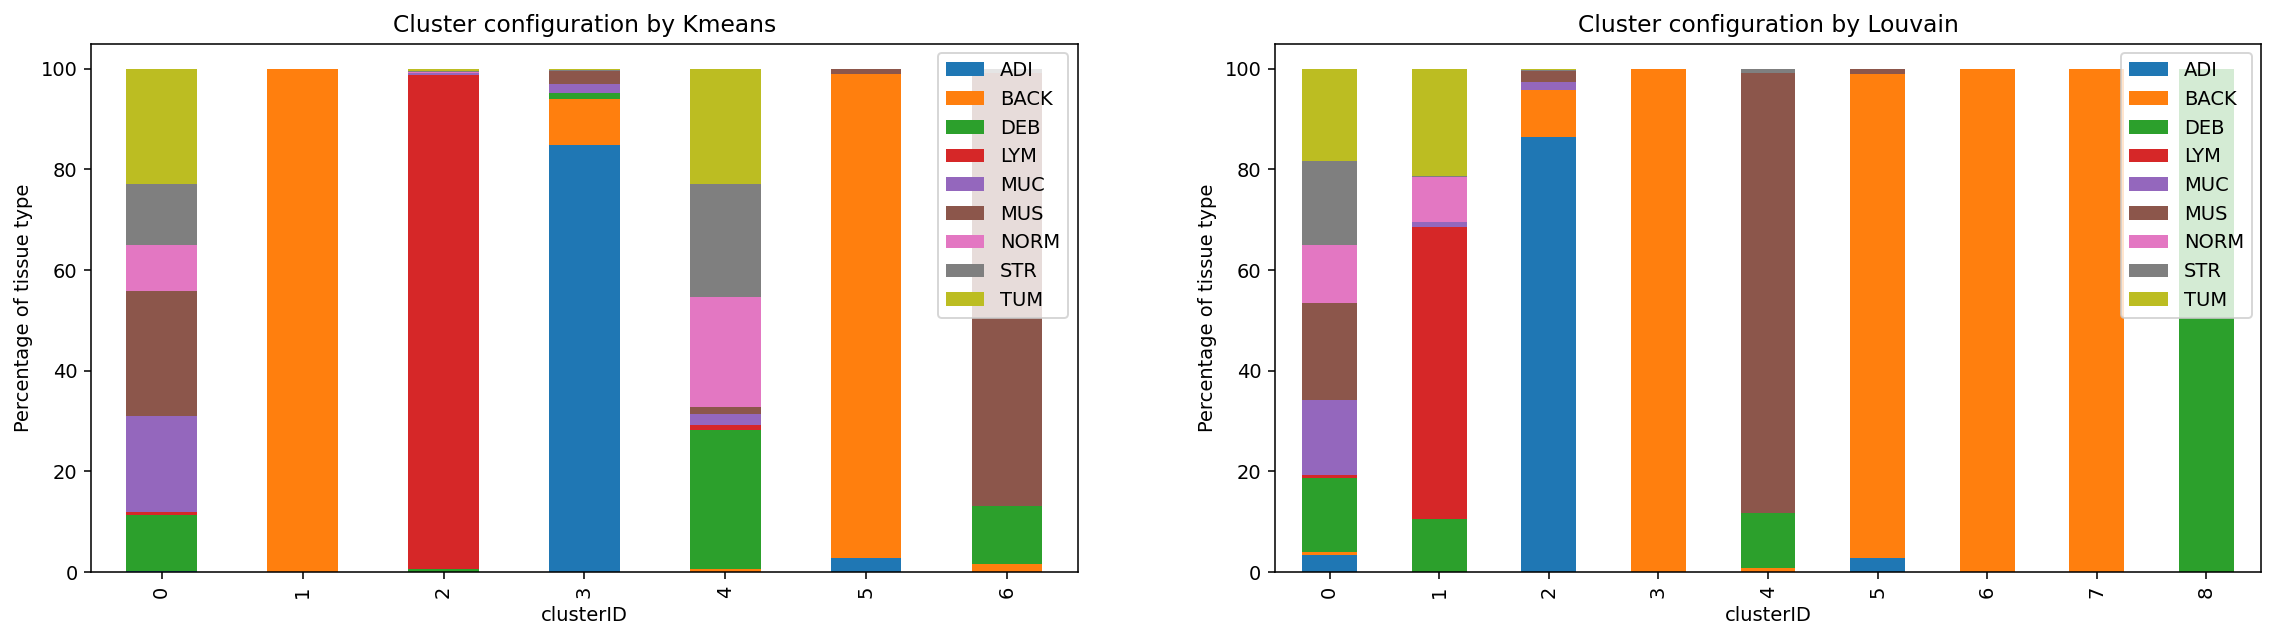

In [29]:
kmeans_model = KMeans(n_clusters = kmeans_maxindex, random_state = 0) 
kmeans_assignment = kmeans_model.fit_predict(pge_umap_feature)

louvain_model = Louvain(resolution = louvian_maxindex, modularity = obj_func, random_state=0) 
adjacency_matrix = sparse.csr_matrix(MinMaxScaler().fit_transform(-pairwise_distances(pge_umap_feature)))
louvain_assignment = louvain_model.fit_transform(adjacency_matrix)

display_info(kmeans_assignment, louvain_assignment, pge_umap_feature)
show_assignments(kmeans_assignment, louvain_assignment)

Best Score is 0.33123019337654114 for Clusters: 2


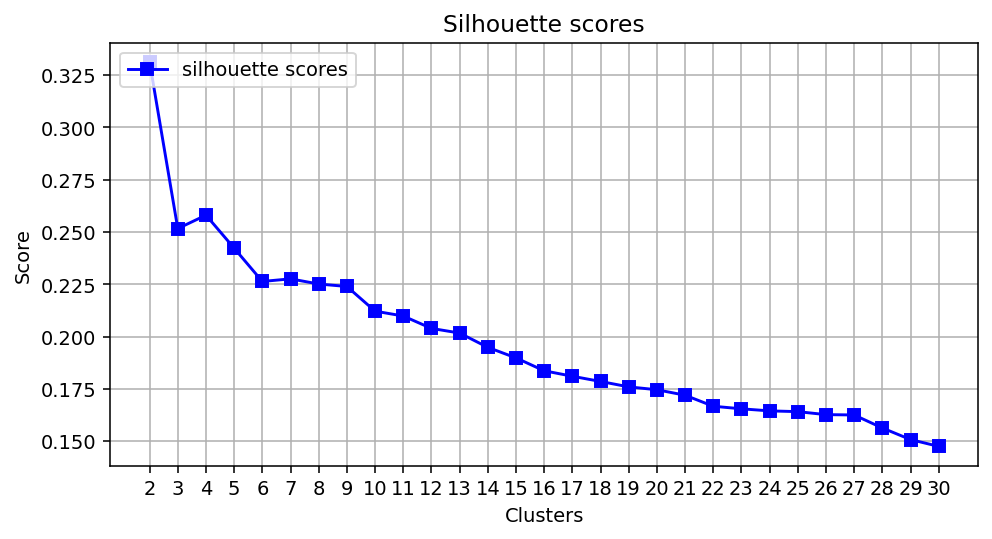

In [30]:
kmeans_silhouettes, kmeans_maxindex = k_means_scores(inceptionv3_pca_feature, cluster)
plot_kmeans_scores(kmeans_silhouettes)
print(f'Best Score is {max(kmeans_silhouettes)} for Clusters: {kmeans_maxindex}')

Best Score is 0.21712712943553925 for Resolution: 0.9


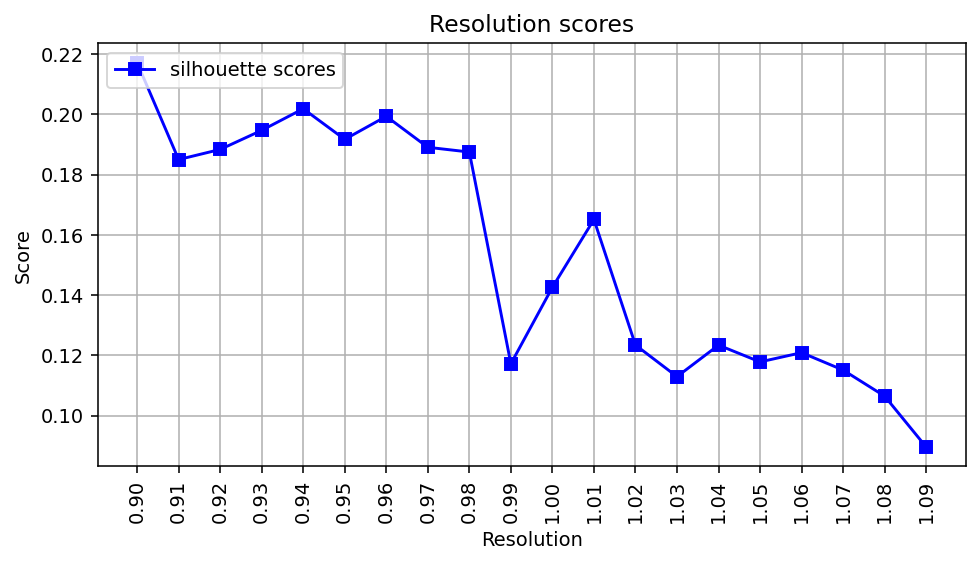

In [31]:
louvian_silhouettes, louvian_maxindex = louvian_scores(inceptionv3_pca_feature, start_res, obj_func, random_state, max_res)
plot_louvian_scores(louvian_silhouettes, start_res, max_res)
print(f'Best Score is {max(louvian_silhouettes)} for Resolution: {louvian_maxindex}')

Kmeans assignment counts


,Number of members
Cluster Index,
0,1207
1,3793


Louvain assignment counts


,Number of members
Cluster Index,
0,3711
1,1112
2,172
3,5


,Kmeans,Louvain
Metrics,,
silhouette,0.331230,0.217127
V-measure,0.209789,0.233625


C:\Users\Sahil Gaurkar\AppData\Local\Temp\ipykernel_14252\2800171252.py:28: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



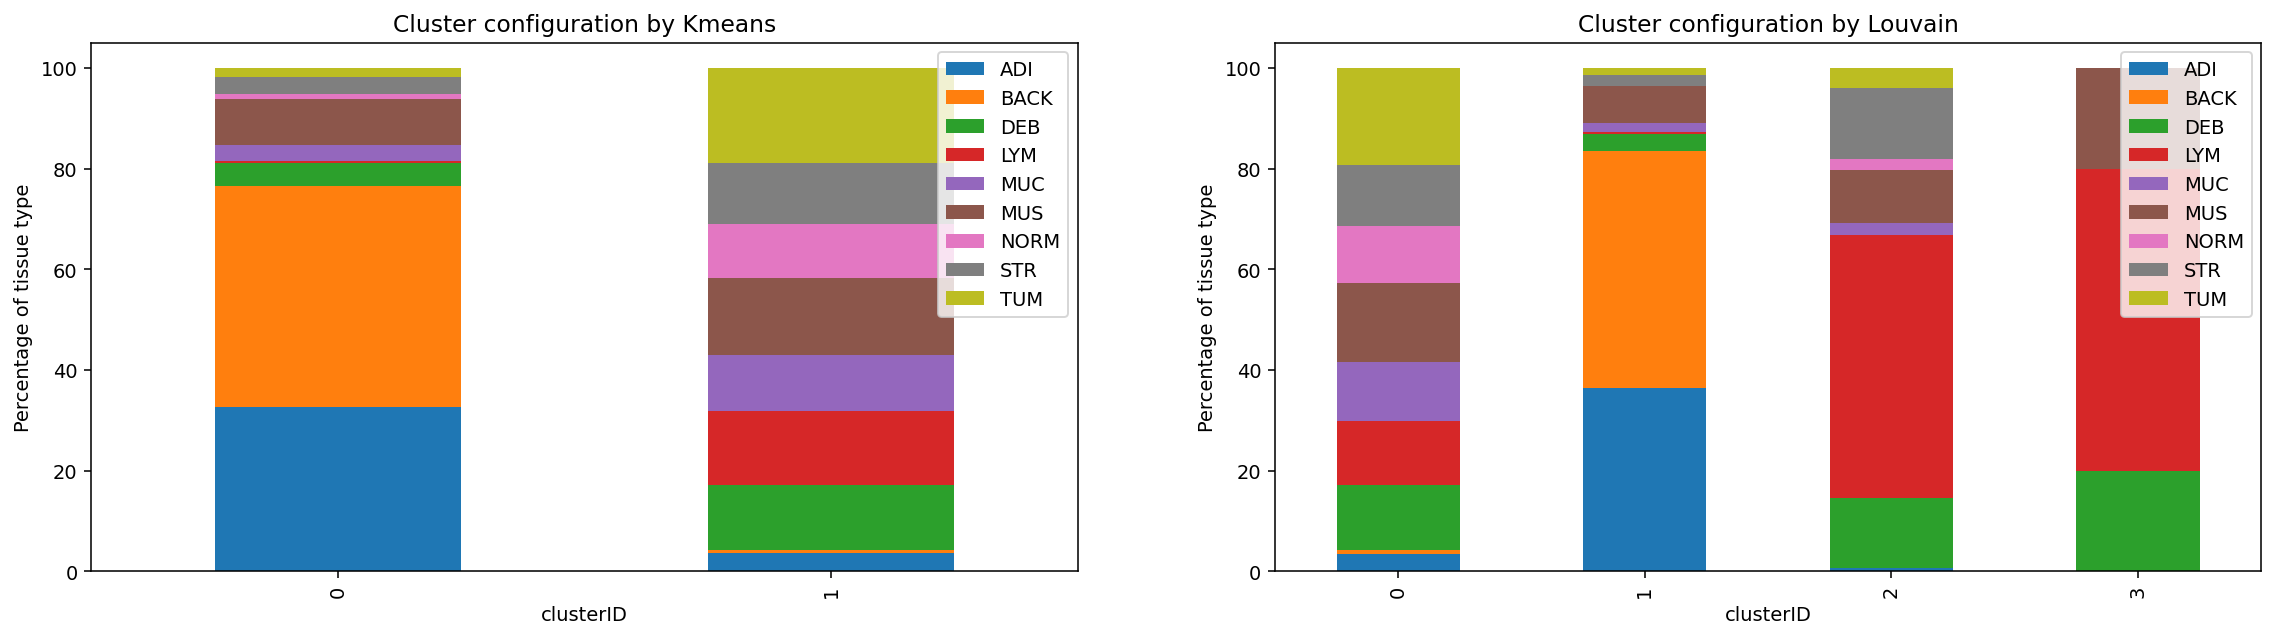

In [32]:
kmeans_model = KMeans(n_clusters = kmeans_maxindex, random_state = 0) 
kmeans_assignment = kmeans_model.fit_predict(inceptionv3_pca_feature)
louvain_model = Louvain(resolution = louvian_maxindex, modularity = obj_func, random_state=0) 
adjacency_matrix = sparse.csr_matrix(MinMaxScaler().fit_transform(-pairwise_distances(inceptionv3_pca_feature)))
louvain_assignment = louvain_model.fit_transform(adjacency_matrix)

display_info(kmeans_assignment,louvain_assignment,inceptionv3_pca_feature)
show_assignments(kmeans_assignment,louvain_assignment)

Best Score is 0.6047378778457642 for Clusters: 2


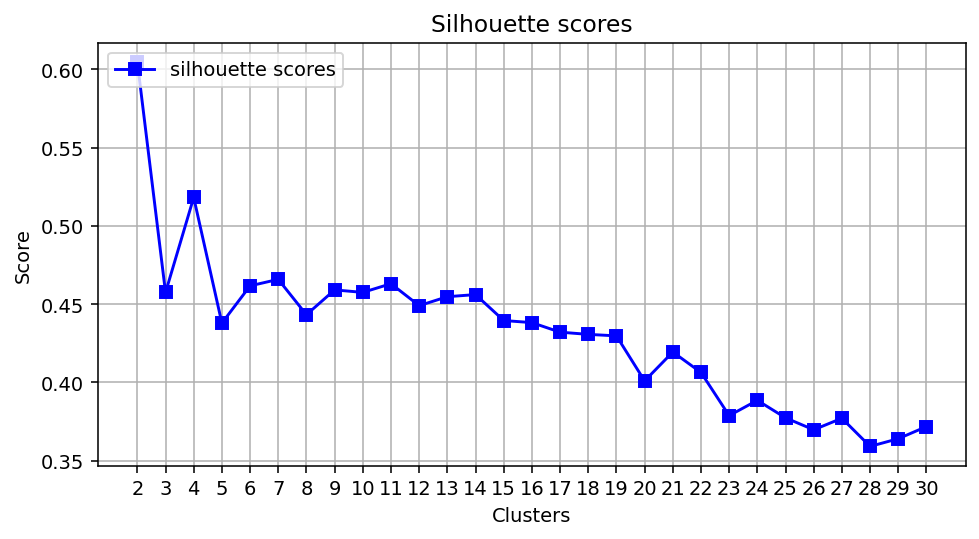

In [33]:
kmeans_silhouettes, kmeans_maxindex = k_means_scores(inceptionv3_umap_feature, cluster)
plot_kmeans_scores(kmeans_silhouettes)
print(f'Best Score is {max(kmeans_silhouettes)} for Clusters: {kmeans_maxindex}')

Best Score is 0.42058897018432617 for Resolution: 1.07


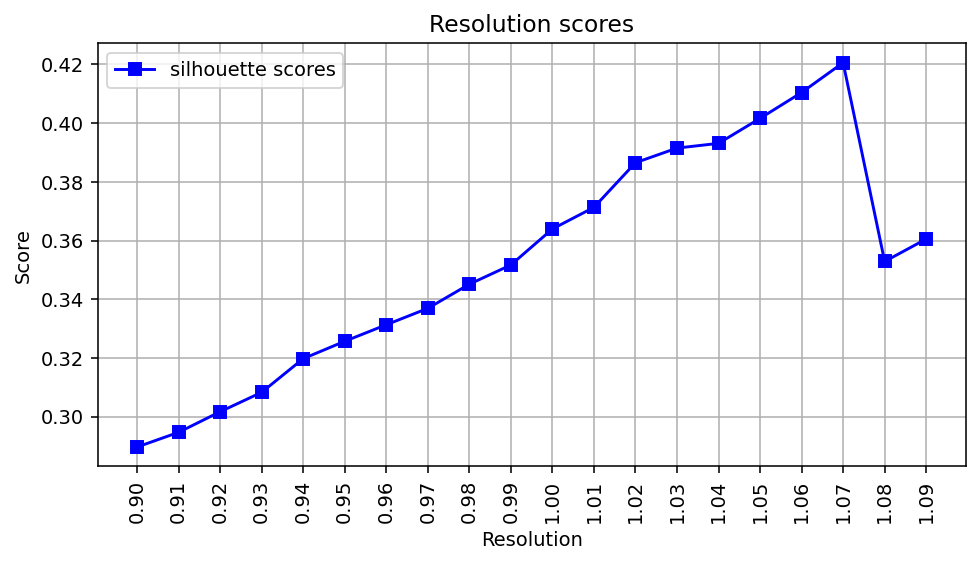

In [34]:
louvian_silhouettes, louvian_maxindex = louvian_scores(inceptionv3_umap_feature, start_res, obj_func, random_state, max_res)
plot_louvian_scores(louvian_silhouettes, start_res, max_res)
print(f'Best Score is {max(louvian_silhouettes)} for Resolution: {louvian_maxindex}')

Kmeans assignment counts


,Number of members
Cluster Index,
0,4670
1,330


Louvain assignment counts


,Number of members
Cluster Index,
0,3127
1,750
2,727
3,328
4,65
5,2
6,1


,Kmeans,Louvain
Metrics,,
silhouette,0.604738,0.420589
V-measure,0.134984,0.345415


C:\Users\Sahil Gaurkar\AppData\Local\Temp\ipykernel_14252\2800171252.py:28: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



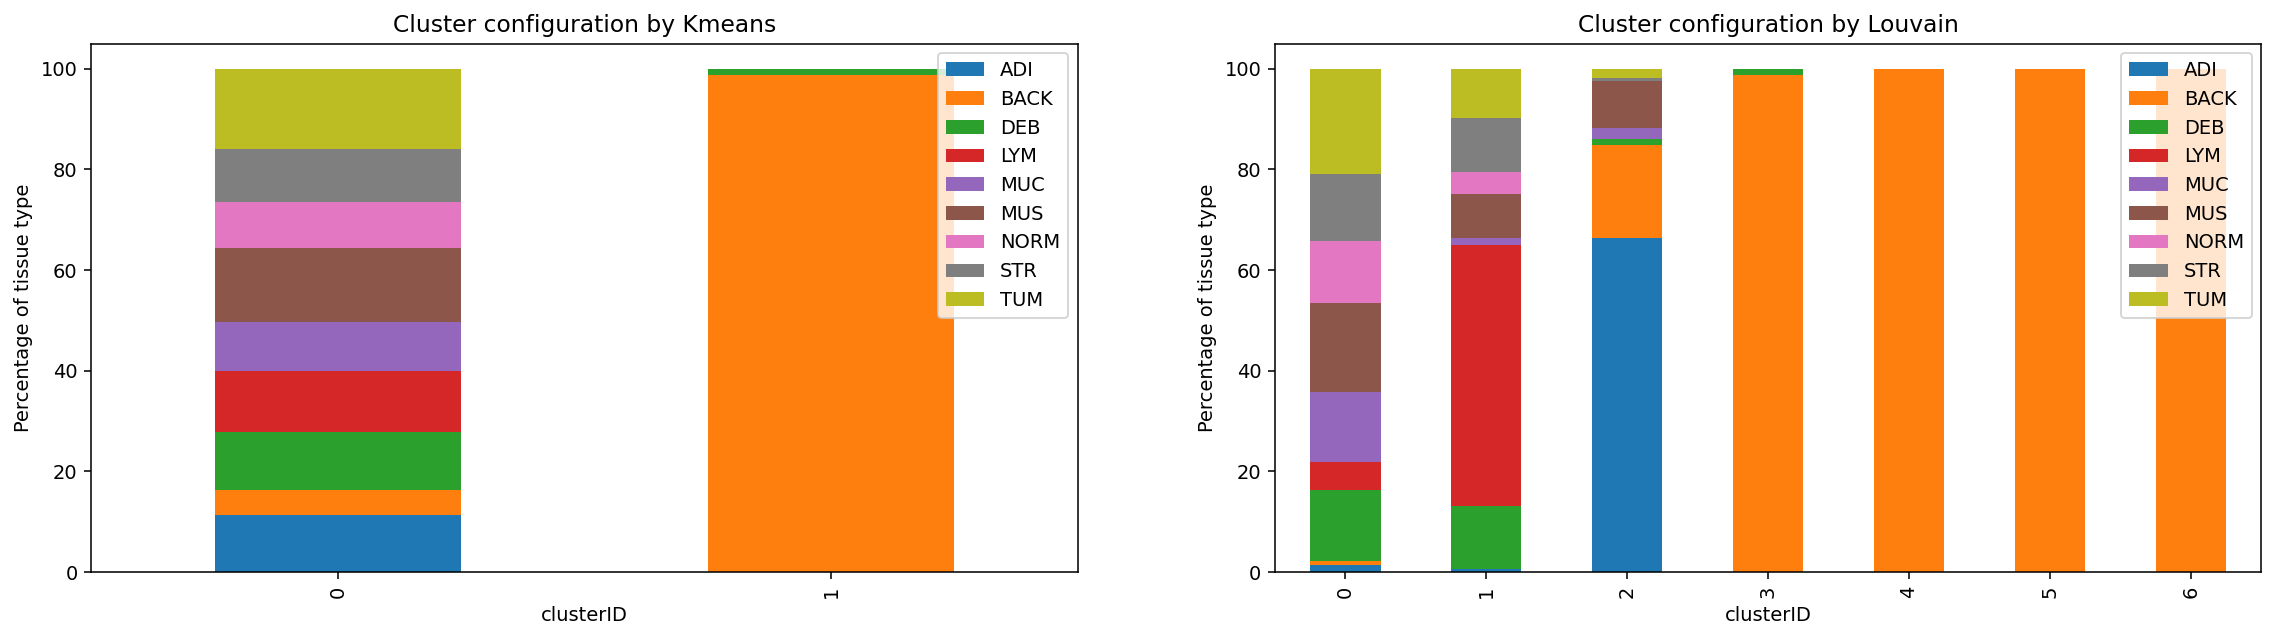

In [35]:
kmeans_model = KMeans(n_clusters = kmeans_maxindex, random_state = 0) 
kmeans_assignment = kmeans_model.fit_predict(inceptionv3_umap_feature)

louvain_model = Louvain(resolution = louvian_maxindex, modularity = obj_func, random_state=0) 
adjacency_matrix = sparse.csr_matrix(MinMaxScaler().fit_transform(-pairwise_distances(inceptionv3_umap_feature)))
louvain_assignment = louvain_model.fit_transform(adjacency_matrix)

display_info(kmeans_assignment,louvain_assignment,inceptionv3_umap_feature)
show_assignments(kmeans_assignment,louvain_assignment)